# Histopathologic Cancer Detection

## Background

We are provided with a large number of small pathology images to classify. The files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. 

We are predicting the labels for the images in the test folder. 

"A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."

## Package Imports

In [1]:
import kaggle
import requests
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Kaggle Connection & Data setup

Had to mess around with the data going from my work laptop to a more powerful pc. Therefore the below cell is used to reference the new data path.

In [11]:
# Specify the competition name
competition = "histopathologic-cancer-detection"
# Path to your Zscaler Root Certificate
zscaler_cert_path = r"C:\txtai\ZscalerRootCA.pem"

# Download the dataset
#kaggle.api.competition_download_files(competition, path='./data', quiet=False)

In [13]:
"""
# Unzip the downloaded files
with zipfile.ZipFile('./data/histopathologic-cancer-detection.zip', 'r') as zip_ref:
    zip_ref.extractall('./data')
"""

"\n# Unzip the downloaded files\nwith zipfile.ZipFile('./data/histopathologic-cancer-detection.zip', 'r') as zip_ref:\n    zip_ref.extractall('./data')\n"

In [10]:
# Load the training labels
path = r'C:\Users\S1013521\OneDrive - Syngenta\2. Data Scientist\1. Masters of Science in Data Science\DTSA 5511 Introduction to Deep Learning\Week Three'
train_labels = pd.read_csv(os.path.join(path,'train_labels.csv'))
print(train_labels.head())

# Display basic information about the labels
print(train_labels.info())

# Check the distribution of the target variable
print(train_labels['label'].value_counts(normalize=True))

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


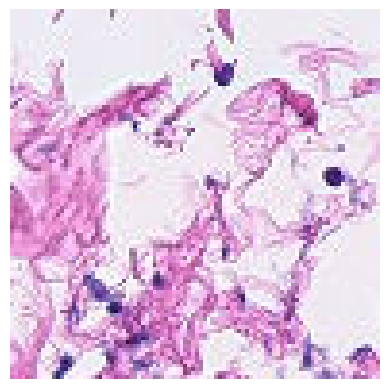

In [11]:
# Display a sample image
sample_image_path = os.path.join(path, 'train', '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
img = Image.open(sample_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

Dataset Details:

- Total images: 277,483 (220,025 training + 57,458 test)
- Image format: TIFF (Tagged Image File Format)
- Image dimensions: 96x96 pixels
- Color mode: RGB (3 channels)
- File size: Typically around 27-28 KB per image

## Extra EDA

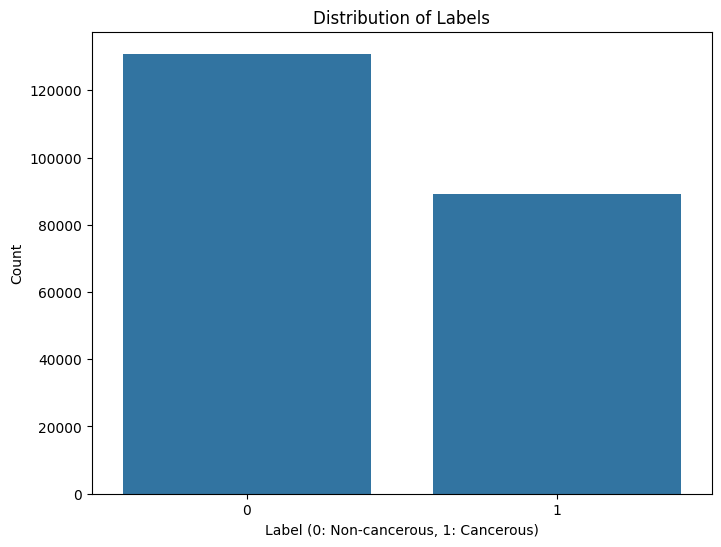

In [12]:
# Visualize label distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=train_labels)
plt.title('Distribution of Labels')
plt.xlabel('Label (0: Non-cancerous, 1: Cancerous)')
plt.ylabel('Count')
plt.show()

In [13]:
# Check for duplicate images
duplicate_images = train_labels[train_labels.duplicated(subset=['id'], keep=False)]
print(f"Number of duplicate image IDs: {len(duplicate_images)}")

Number of duplicate image IDs: 0


In [14]:
# Check for missing values
print(train_labels.isnull().sum())

id       0
label    0
dtype: int64


## Plan

My intital thoughts for analysis are to normalise the pixel values to [0, 1], implement some data augmentation such as rotation, flipping, and colour jittering. We also need to split the data into 70% train, 15% validation, and 15% test (stratified).

I then want to develop some different models to compare the results and then I can complete some hyperparameter tuning.

I can first create a custom CNN model to serve as a baseline to compare more advanced methods against. 

## Model Building

In [15]:
# Convert the 'label' column to string
train_labels['label'] = train_labels['label'].astype(str)
train_labels['id_tif'] = train_labels['id'] + '.tif'

print(train_labels.head())

image_dir = os.path.join(path, 'train')

                                         id label  \
0  f38a6374c348f90b587e046aac6079959adf3835     0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77     1   
2  755db6279dae599ebb4d39a9123cce439965282d     0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08     0   
4  068aba587a4950175d04c680d38943fd488d6a9d     0   

                                         id_tif  
0  f38a6374c348f90b587e046aac6079959adf3835.tif  
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif  
2  755db6279dae599ebb4d39a9123cce439965282d.tif  
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif  
4  068aba587a4950175d04c680d38943fd488d6a9d.tif  


In [16]:
# Split the data
train_val, test = train_test_split(train_labels, test_size=0.15, stratify=train_labels['label'], random_state=42)
train, val = train_test_split(train_val, test_size=0.15/(0.85), stratify=train_val['label'], random_state=42)

# Reset indices
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

# Create ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Set up the generators
batch_size = 32

train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_dir,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    validate_filenames=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=val,
    directory=image_dir,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    validate_filenames=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test,
    directory=image_dir,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    validate_filenames=True
)

print(f"Number of training samples: {len(train)}")
print(f"Number of validation samples: {len(val)}")
print(f"Number of test samples: {len(test)}")

Found 154017 validated image filenames belonging to 2 classes.
Found 33004 validated image filenames belonging to 2 classes.
Found 33004 validated image filenames belonging to 2 classes.
Number of training samples: 154017
Number of validation samples: 33004
Number of test samples: 33004


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

### Simple CNN Baseline

In [28]:
"""
Reasoning: A simple custom CNN serves as a baseline. It's lightweight and can capture basic features, 
but may lack the capacity to learn complex patterns in histopathological images.
"""
def create_model(input_shape=(96, 96, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = create_model()

# Print model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,638,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,694,849 (6.47 MB)

 Trainable params: 1,694,849 (6.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4813/4813 ━━━━━━━━━━━━━━━━━━━━ 223s 46ms/step - accuracy: 0.7648 - loss: 0.4818 - val_accuracy: 0.8450 - val_loss: 0.3688
Epoch 2/50
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7812 - loss: 0.3073 - val_accuracy: 0.8333 - val_loss: 0.3248
Epoch 3/50


C:\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4813/4813 ━━━━━━━━━━━━━━━━━━━━ 154s 32ms/step - accuracy: 0.8608 - loss: 0.3282 - val_accuracy: 0.8792 - val_loss: 0.2851
Epoch 4/50
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.6875 - loss: 0.4944 - val_accuracy: 0.9167 - val_loss: 0.2288
Epoch 5/50
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 154s 32ms/step - accuracy: 0.8844 - loss: 0.2782 - val_accuracy: 0.8938 - val_loss: 0.2567
Epoch 6/50
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 5us/step - accuracy: 0.7812 - loss: 0.4586 - val_accuracy: 0.9167 - val_loss: 0.1650
Epoch 7/50
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 155s 32ms/step - accuracy: 0.9024 - loss: 0.2384 - val_accuracy: 0.8734 - val_loss: 0.3115
Epoch 8/50
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.9062 - loss: 0.2517 - val_accuracy: 0.8333 - val_loss: 0.3980
Epoch 9/50
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 155s 32ms/step - accuracy: 0.9197 - loss: 0.1990 - val_accuracy: 0.8920 - val_loss: 0.2827
Epoch 10/50
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.8750 - loss: 0.2832 

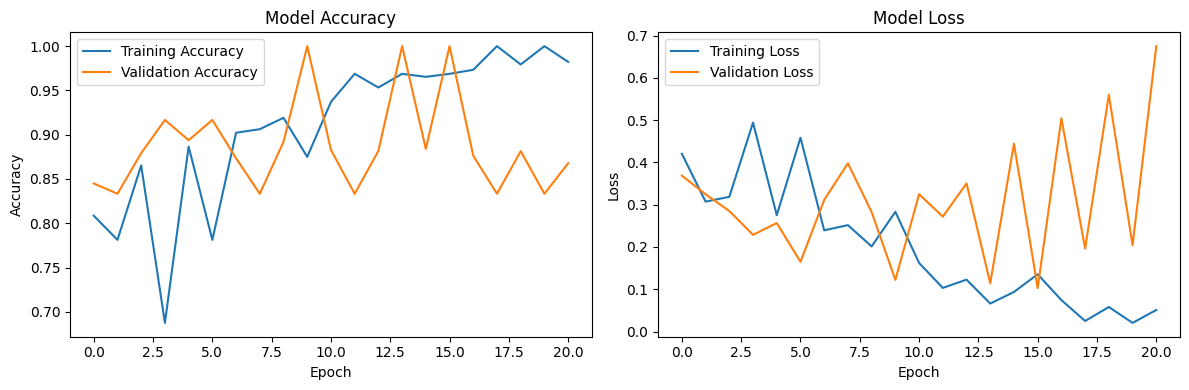

In [29]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train) // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val) // batch_size,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test) // batch_size)
print(f"Test accuracy: {test_accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
from sklearn.metrics import confusion_matrix
# Function for Confusion matrix plotting
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

1032/1032 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step


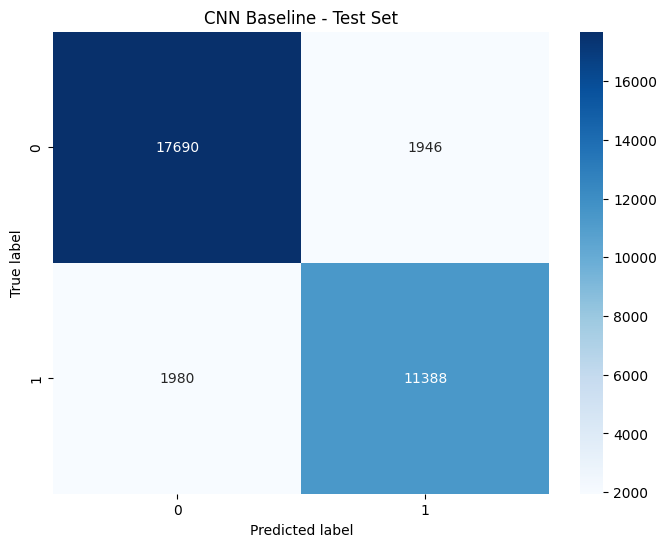

In [33]:
# CNN Baseline
def get_predictions(model, generator):
    generator.reset()
    predictions = model.predict(generator, steps=len(generator))
    return (predictions > 0.5).astype(int).reshape(-1)

# Test set
test_pred = get_predictions(model, test_generator)
plot_confusion_matrix(test_generator.classes[:len(test_pred)], test_pred, 'CNN Baseline - Test Set')

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Model Architecture

My baseline CNN model is performing reasonably well, with some fuctuations in training and validation accuracy and loss that suggest some instability or overfitting as the training progresses. 

My initial architecture is quite large which, along with a small learning rate, caused the model to take a long time to run. My inital architecture is:
- Input Layer: Accepts images of size 96x96x3.
- Convolutional Layers: Three convolutional layers with increasing filter sizes (32, 64, 64) and a kernel size of 3x3. These layers are responsible for feature extraction.
- MaxPooling Layers: Placed after each convolutional layer to reduce spatial dimensions and enhance the detection of features at various scales.
- Flatten Layer: Converts the 2D feature maps into a 1D feature vector.
- Dense Layers: A dense layer with 64 units followed by a sigmoid output layer for binary classification.
  

To further improve this model I could experiment with deeper architectures by adding more convolutional layers which may help the learning of more complex patterns in the images. I can also incorporate batch normalisation to stabilise learning and improve convergence rates. 

Using a different optimiser such as SGD with momentum or RMSprop, which may offer better control over learning rates and convergence. I could also look to implment learning rate decay to avoid overshooting during training. 

### Tuning

In [8]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import activations
from keras_tuner import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

In [22]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,801 (6.61 MB)

 Trainable params: 1,732,353 (6.61 MB)

 Non-trainable params: 448 (1.75 KB)

#### Utilise SGD

**SGD with Momentum**

Momentum helps accelerate SGD in the right direction, thus leading to faster converging. It is particularly useful when you need to navigate along flat regions of the loss surface or when escaping local minima.

In [23]:
# Define the optimizer with momentum
optimizer = SGD(learning_rate=0.01, momentum=0.9)

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
# Set the number of epochs for training
epochs = 30

# Start training the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train) // batch_size,  # Ensure model sees all samples
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=len(val) // batch_size,  # Ensure model sees all validation samples
    verbose=1
)

Epoch 1/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 261s 54ms/step - accuracy: 0.7542 - loss: 0.5466 - val_accuracy: 0.8448 - val_loss: 0.3677
Epoch 2/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.7500 - loss: 0.5035 - val_accuracy: 0.8333 - val_loss: 0.3405
Epoch 3/30


C:\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4813/4813 ━━━━━━━━━━━━━━━━━━━━ 264s 55ms/step - accuracy: 0.8348 - loss: 0.3818 - val_accuracy: 0.6990 - val_loss: 1.2063
Epoch 4/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.8125 - loss: 0.3363 - val_accuracy: 0.9167 - val_loss: 0.3378
Epoch 5/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 266s 55ms/step - accuracy: 0.8666 - loss: 0.3256 - val_accuracy: 0.8344 - val_loss: 0.4091
Epoch 6/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step - accuracy: 0.8438 - loss: 0.4227 - val_accuracy: 0.9167 - val_loss: 0.1742
Epoch 7/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 265s 55ms/step - accuracy: 0.8795 - loss: 0.2944 - val_accuracy: 0.8889 - val_loss: 0.2934
Epoch 8/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.9375 - loss: 0.2893 - val_accuracy: 0.9167 - val_loss: 0.3533
Epoch 9/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 262s 54ms/step - accuracy: 0.8907 - loss: 0.2699 - val_accuracy: 0.8939 - val_loss: 0.2556
Epoch 10/30
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.8750 - loss: 0.2653 

In [52]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test) // batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1031/1031 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.8822 - loss: 0.3434
Test Loss: 0.34332847595214844
Test Accuracy: 0.8812439441680908


1032/1032 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step


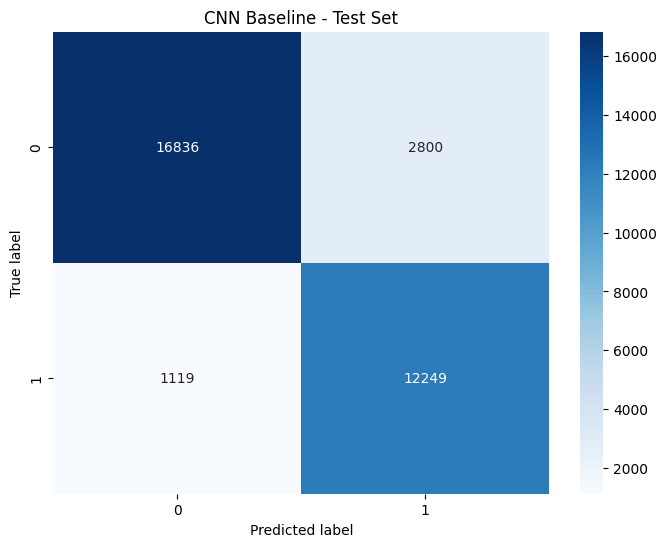

In [54]:
# Ensure the generator is not shuffling data
test_generator.shuffle = False
test_generator.reset()

# Test set
test_pred = get_predictions(model, test_generator)
plot_confusion_matrix(test_generator.classes[:len(test_pred)], test_pred, 'CNN Baseline - Test Set')

### Another Architecture
- Fewer Convolutional Layers
- Fewer Filters: The Conv2D layers have fewer filters (16 and 32 instead of 32, 64, and 128).
- No Batch Normalization: BatchNormalization layers have been removed.
- Simpler Dense Layer: There's only one Dense layer before the output, with fewer neurons (64 instead of 128).
- No Dropout: The Dropout layer has been removed, reducing regularization.
- Reduction to epochs and increase to learning rate

In [18]:
# Define a simpler model architecture
model2 = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Define the optimizer with momentum
optimizer_mdl2 = SGD(learning_rate=0.1, momentum=0.9)

# Compile the model
model2.compile(optimizer=optimizer_mdl2, loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model2.summary()

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 94, 94, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 47, 47, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         991,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 996,449 (3.80 MB)

 Trainable params: 996,449 (3.80 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Set the number of epochs for training
epochs2 = 20

# Start training the model
history2 = model2.fit(
    train_generator,
    steps_per_epoch=len(train) // batch_size,  # Ensure model sees all samples
    epochs=epochs2,
    validation_data=val_generator,
    validation_steps=len(val) // batch_size,  # Ensure model sees all validation samples
    verbose=1
)
model2.save('bad_cnn_model.h5')

Epoch 1/20


C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4813/4813 ━━━━━━━━━━━━━━━━━━━━ 206s 43ms/step - accuracy: 0.5942 - loss: 0.6776 - val_accuracy: 0.5949 - val_loss: 0.6841
Epoch 2/20
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - accuracy: 0.5625 - loss: 0.6877 - val_accuracy: 0.7500 - val_loss: 0.6707
Epoch 3/20


C:\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


4813/4813 ━━━━━━━━━━━━━━━━━━━━ 125s 26ms/step - accuracy: 0.5951 - loss: 0.6769 - val_accuracy: 0.5949 - val_loss: 0.6786
Epoch 4/20
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - accuracy: 0.5312 - loss: 0.6922 - val_accuracy: 0.7500 - val_loss: 0.6424
Epoch 5/20
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 124s 26ms/step - accuracy: 0.5954 - loss: 0.6767 - val_accuracy: 0.5949 - val_loss: 0.6769
Epoch 6/20
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 3us/step - accuracy: 0.6875 - loss: 0.6297 - val_accuracy: 0.7500 - val_loss: 0.5994
Epoch 7/20
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 125s 26ms/step - accuracy: 0.5950 - loss: 0.6769 - val_accuracy: 0.5949 - val_loss: 0.6752
Epoch 8/20
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.6875 - loss: 0.6436 - val_accuracy: 0.7500 - val_loss: 0.6170
Epoch 9/20
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 126s 26ms/step - accuracy: 0.5933 - loss: 0.6775 - val_accuracy: 0.5949 - val_loss: 0.6754
Epoch 10/20
4813/4813 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step - accuracy: 0.5312 - loss: 0.7035 

In [87]:
# Apply my model with SGD to the test_data
path2 = r'C:\deep_learning\Scripts\data'
image_dir3 = os.path.join(path2, 'test')

In [90]:
# List all files in the test directory
test_files = [f for f in os.listdir(image_dir3) if f.endswith('.tif')]  # Adjust the extension based on your files
test_df = pd.DataFrame({
    'filename': test_files
})

In [95]:
print(len(test_df))
print(test_df.head())

57458
                                       filename
0  00006537328c33e284c973d7b39d340809f7271b.tif
1  0000ec92553fda4ce39889f9226ace43cae3364e.tif
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3  000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4  000270442cc15af719583a8172c87cd2bd9c7746.tif


In [93]:
# Create ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [97]:
# Set up the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir3,
    x_col='filename',
    y_col=None,  # No labels for test data
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [107]:
# Predict
predictions = model.predict(test_generator, steps=int(np.ceil(len(test_df)/32)), verbose=1)

# Assuming binary classification and you need class labels
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Create a DataFrame to store results
results_df = pd.DataFrame({
    'filename': test_files,
    'label': predicted_classes
})

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step


In [112]:
count = (results_df['label'] == 1).sum()
print(count)
print(results_df.head())

5421
   label                                            id
0      0  00006537328c33e284c973d7b39d340809f7271b.tif
1      0  0000ec92553fda4ce39889f9226ace43cae3364e.tif
2      0  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif
3      0  000253dfaa0be9d0d100283b22284ab2f6b643f6.tif
4      0  000270442cc15af719583a8172c87cd2bd9c7746.tif


In [119]:
results_df = results_df[['id', 'label']]  # Reorder the columns
# Remove '.tif' from the 'id' column
results_df['id'] = results_df['id'].str.replace('.tif', '', regex=False)
print(results_df.head())

                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      0
1  0000ec92553fda4ce39889f9226ace43cae3364e      0
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      0
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4  000270442cc15af719583a8172c87cd2bd9c7746      0


In [120]:
# Save the results to a CSV file
results_path = os.path.join(path2, 'test_predictions.csv')
results_df.to_csv(results_path, index=False)

print(f"Predictions saved to {results_path}")
print(results_df.head())  # Show some of the predictions

Predictions saved to C:\deep_learning\Scripts\data\test_predictions.csv
                                         id  label
0  00006537328c33e284c973d7b39d340809f7271b      0
1  0000ec92553fda4ce39889f9226ace43cae3364e      0
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      0
3  000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4  000270442cc15af719583a8172c87cd2bd9c7746      0


## Conclusion

By using SGD with momentum and a slightly larger convolution network I have been able to improve the confusion matrix by roughly 800 for the predicted 0 with true lable 1. However, I have reduced the number of FALSE NEGATIVES (type 2 error) from the previous model, which in this case would be determined as a worse outcome and a Type 1 error would be preferred in the case of cancer prediction. 

Using a better optimiser such as SGD did help improve the performance of my model creation but the overall size, epochs and training rate still make the model building process slow. In the future I intend to do more playing with learning rates and I am also interested in making plots of the loss like we have seen in the content. I would also like to visualise the Neural Network architecture, which I attempted but could not get working.

Overall, I have created a satisfactory model with roughly 0.88 accuracy on my test split of the training data.

Trouble shooting:
- I had some issues with building a simple CNN that could perform quickly.
- I also had issues with creating and using some of the keras packages effectively but after many tries I got my head around being able to use them.

### Score

My submission received a score of 0.4921 (private) and 0.4786 (public).